## Fourier Transform: <br>
- version: 1_2 <br>
This code constructs initial condition using StabilityPartOnly, uses FFT to Fourier transform the Kawhara $u_t=\alpha u_{3x} + \beta u_{5x} + 2\sigma uu_x + cu_x$ and solves the system of ODEs, using odeint and outputs the solution in an animation.
<br>
<br>
- version summary :
- Initial condition bugs fixed
- FFTKawahara bugs fixed
- The nonlinear term is defined using FFT only
- Documented
- Includes FFT Testing
- FFTKawahara has damping and driving options
<br>
<br>
- Problems:
- pay close attention to dt/dx as including too many modes (N=nx) when dt is considered large can lead to large numerical errors.

In [1036]:
# preliminaries
import pandas as pd
import numpy as np
import scipy as sc



import matplotlib

import matplotlib.pyplot as plt 

from math import *

import scipy.optimize as so
from scipy.optimize import fsolve
from mpl_toolkits.mplot3d import axes3d
import matplotlib.cm as cm

from scipy.fftpack import fft, ifft
from scipy.integrate import odeint


In [1037]:
### parameters ###

alpha=1
beta=0
sigma=1/5
c=alpha-beta
c=0# speed of the frame of reference

In [1053]:
L=2*np.pi # Period

N=20 # number of frequencies from -N/2 to N/2
nx=N # making sure we have nx kappas
dx = L/(N-1)

      
x = np.linspace(0,L,N+1) # define space


tFinal=4 # final time
nt = 2000# number of time steps
dt = tFinal/(nt-1)

t = np.linspace(0,tFinal,nt) # define time



kappa = 2*np.pi/L*np.arange(-N/2,int((N+2)/2)) # define frequencies, from -N/2 to N/2, from negative to positive

# kappashift=np.fft.fftshift(kappa)


In [1054]:
### Interpolation matrix ###
cutoff=3 # number of frequencies to be chopeed from the two ends of frequency spectrum
Identity=np.identity(len(kappa))
Identity[:cutoff,:]=np.zeros((1,len(kappa)))
Identity[len(kappa)-cutoff:,:]=np.zeros((1,len(kappa)))


In [1055]:
v=np.cos(x)+np.cos(4*x) # IC to the nudged equation
u=np.cos(x)+1/2*np.cos(2*x) # IC to the kawahara/data
u0hat=np.fft.fft(u) # fft 
u0hat=np.fft.fftshift(u0hat) 
# Note: we shift u and v instead of kappas so that interpolation matrix works correctly
v0hat=np.fft.fft(v)
v0hat=np.fft.fftshift(v0hat)

u0hat_ri=np.concatenate((u0hat.real,u0hat.imag)) # size 2N
v0hat_ri=np.concatenate((v0hat.real,v0hat.imag)) # size 2N
print(u0hat_ri.shape)
IC=np.hstack((u0hat_ri,v0hat_ri)) # IC vector size 4N
print(IC.shape)


(42,)
(84,)


## Function: FFTKawahara <br>
FFTKawahara outputs the FFT of Kawahara <br>
### Input parameters:<br>
- uhat_ri: initial condition in Fourier space <br>
- kappa: list of frequencies <br>
- alpha,beta,sigma: $\alpha$,$\beta$,$\sigma$ from the Kawahara <br>
- gamma: coefficient of damping term $\gamma u_{xx}$, default value is 0 <br>
- driven: driving/forcing term. The valid entires are as it follows: 
    - 0: no driving term<br>
    - 1: $\cos(kx-\omega t)$. Note that the default value of $k$ and $\omega$ is $0$
    - 2: $\omega t \cos(kx)$.  Note that the default value of $k$ and $\omega$ is $0$
<br>

### Output parameters:<br>
- Fourier transformed Kawahara in the form of a system of time ODEs, vector 2kappa long (real and imaginary parts), where for every kappa we have two $\hat{u}_t=(i\kappa)^3\alpha \hat{u} + (i\kappa)^5\beta \hat{u} + (ik) c \hat{u} + 2\sigma fft(ifft(\hat{u})ifft(i\kappa \hat{u})) + \gamma(i\kappa)^2 \hat{u}+ f(x,t)$ <br>
<br>
Example use: <br>

FFTKawahara(u0hat_ri,0,kappa,alpha,beta,sigma,gamma=0,driven=0,k=0,omega=0)

In [1056]:
nudg=80 # nudging coefficient 

def FFTKawahara(condition,t,kappa,alpha,beta,sigma):
    # separating inital conditions for u and v
    uhat_ri=condition[:len(kappa)*2]
    vhat_ri=condition[len(kappa)*2:]


    duhat=np.zeros((2*len(kappa)),dtype='complex128') # vector of ODEs, 2N long, first half is u, second half is v
    uhatreal=uhat_ri[:N+1]
    uhatim=uhat_ri[N+1:]
    vhatreal=vhat_ri[:N+1]
    vhatim=vhat_ri[N+1:]
    uhat=uhatreal+1j*uhatim # size N
    vhat=vhatreal+1j*vhatim # size N
    
    # interpolate/chopp off frequencies for real and imaginary parts separately   
    Ihvreal=np.dot(Identity,vhatreal)
    Ihureal=np.dot(Identity,uhatreal)
    Ihvim=np.dot(Identity,vhatim)
    Ihuim=np.dot(Identity,uhatim)
    Ihv=Ihvreal+1j*Ihvim # size N
    Ihu=Ihureal+1j*Ihuim # size N

    # nonlinear parts for u and v
    nonlinear=np.real(np.fft.fftshift(np.fft.fft(np.fft.ifft(np.fft.ifftshift(uhat))*np.fft.ifft(np.fft.ifftshift(1j*kappa*uhat)))))
    nonlinearv=np.fft.fftshift(np.fft.fft(np.real(np.fft.ifft(np.fft.ifftshift(vhat)))*np.real(np.fft.ifft(np.fft.ifftshift(1j*kappa*vhat)))))
    for i in range(len(kappa)):
        duhat[i]=alpha*(1j*kappa[i])**3*uhat[i]+beta*(1j*kappa[i])**5*uhat[i]+c*(1j*kappa[i])*uhat[i]+2*sigma*nonlinear[i]
    for i in range(len(kappa)):
        duhat[i+len(kappa)]=alpha*(1j*kappa[i])**3*vhat[i]+beta*(1j*kappa[i])**5*vhat[i]+c*(1j*kappa[i])*vhat[i]+2*sigma*nonlinearv[i]-nudg*(Ihv[i]-Ihu[i])
                                                                                                                                  
                                                                                                                                  
                                                                                                                                  
    
    duhat_ri=np.concatenate((duhat[:len(kappa)].real,duhat[:len(kappa)].imag,duhat[len(kappa):].real,duhat[len(kappa):].imag)).astype('float64') # size 4N

    return duhat_ri

## Integration: <br>
the following cell integrates FFTKawhara using odeint and applies inverse Fourier transform to the function

In [1057]:

solution=odeint(FFTKawahara,IC,t,args=(kappa,alpha,beta,sigma))

import os
os.system('say "your program has finished"')

0

In [1058]:
uhat=solution[:,:N+1]+1j*solution[:,N+1:2*(N+1)]
vhat=solution[:,2*(N+1):3*(N+1)]+1j*solution[:,3*(N+1):]
print(uhat.shape,vhat.shape)

(2000, 21) (2000, 21)


In [1059]:
u=np.zeros((uhat.shape))

for k in range(len(t)):
     u[k,:]=np.fft.ifft(np.fft.ifftshift(uhat[k,:]))

u=u.real


v=np.zeros((vhat.shape))

for k in range(len(t)):
     v[k,:]=np.fft.ifft(np.fft.ifftshift(vhat[k,:]))

v=v.real


/Users/nadiaaiaseh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  after removing the cwd from sys.path.
/Users/nadiaaiaseh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  if sys.path[0] == '':


/Users/nadiaaiaseh/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


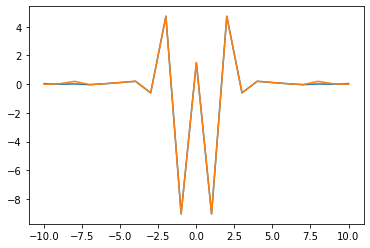

In [1060]:
plt.plot(kappa,uhat[nt-1,:],kappa,vhat[nt-1,:])

Text(0, 0.5, 'largest absolute difference')

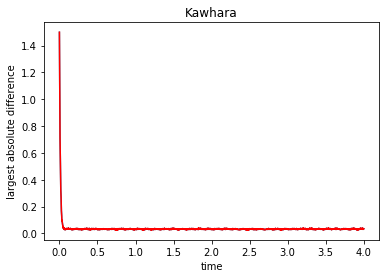

In [1061]:
from numpy import linalg as LA

growth=np.zeros((1,nt))
growth2=np.zeros((1,nt))
for time in range(nt):
    growth[0,time]=np.max(abs(u[time,:]-v[time,:]))
    growth2[0,time]=LA.norm(u[time,:]-v[time,:], np.inf)

plt.plot(t,growth.transpose())    
plt.plot(t,growth2.transpose(),'r')  
plt.title('Kawhara')
plt.xlabel('time')
plt.ylabel('largest absolute difference')


## Animation

In [1062]:
from matplotlib import animation, rc
from IPython.display import HTML

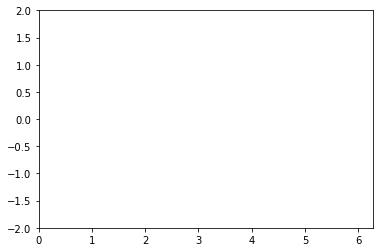

In [1063]:
fig, ax = plt.subplots()

ax.set_xlim(( 0, L))
ax.set_ylim((-2, 2))

line, = ax.plot([], [], lw=2)
line2, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    line2.set_data([], [])
    return (line,line2,)

In [1064]:
def animate(i):
    y=u[i,:]
    y2=v[i,:]
    line.set_data(x,y,)
    
    line2.set_data(x,y2)
    
    return(line,line2,)

In [1065]:
# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=int((nt-1)/10), interval=100) #frames is nt

In [1066]:

HTML(anim.to_jshtml())

## Amplitude growth Analysis:

nx is: 31 dx is: 0.20943951023931953
nt is: 1000 dt is 0.0005005005005005005
ratio dt/dx is 0.002389713860238669


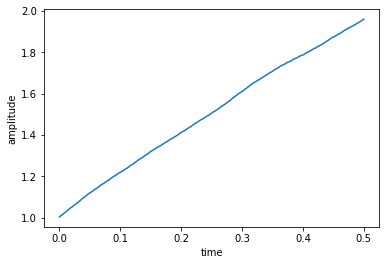

In [1182]:
# for every time step, the largest difference in the solution is taken as amplitude and plotted over time
amp=np.zeros((1,nt))
for time in range(nt):
    amp[0,time]=np.max(np.max(u[time,:])-np.min(u[time,:]))

plt.plot(t,amp.transpose())


plt.xlabel('time')
plt.ylabel('amplitude')
print('nx is:',nx,'dx is:',dx)
print('nt is:',nt, 'dt is',dt)
print('ratio dt/dx is',dt/dx)
